## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn  import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col = 0, parse_dates = True)

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df = df.resample("1H").sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

In [8]:
print(df.index.is_monotonic)

True


Text(0.5, 0, 'Время')

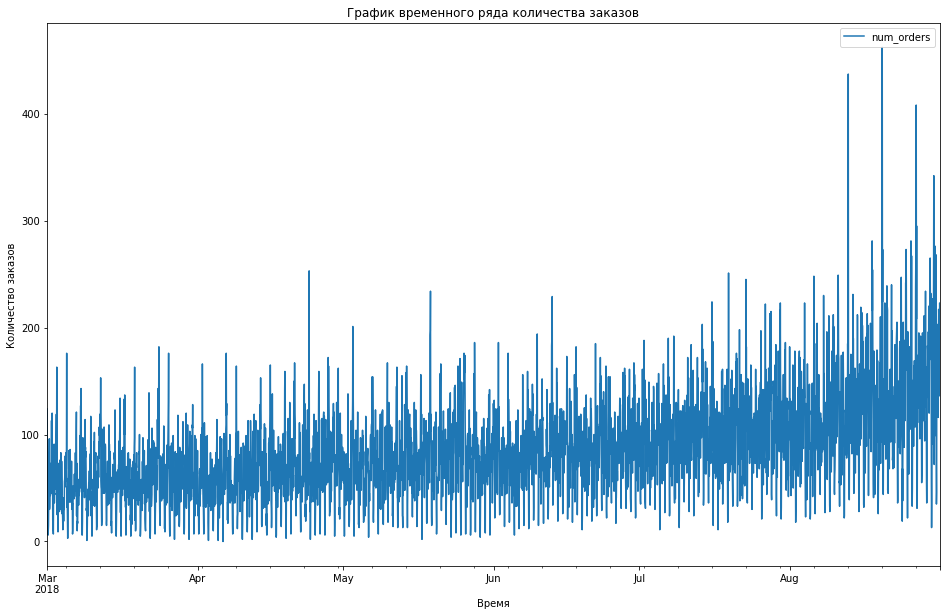

In [9]:
ax = df.plot(figsize=(16, 10))
ax.set_title("График временного ряда количества заказов")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время")

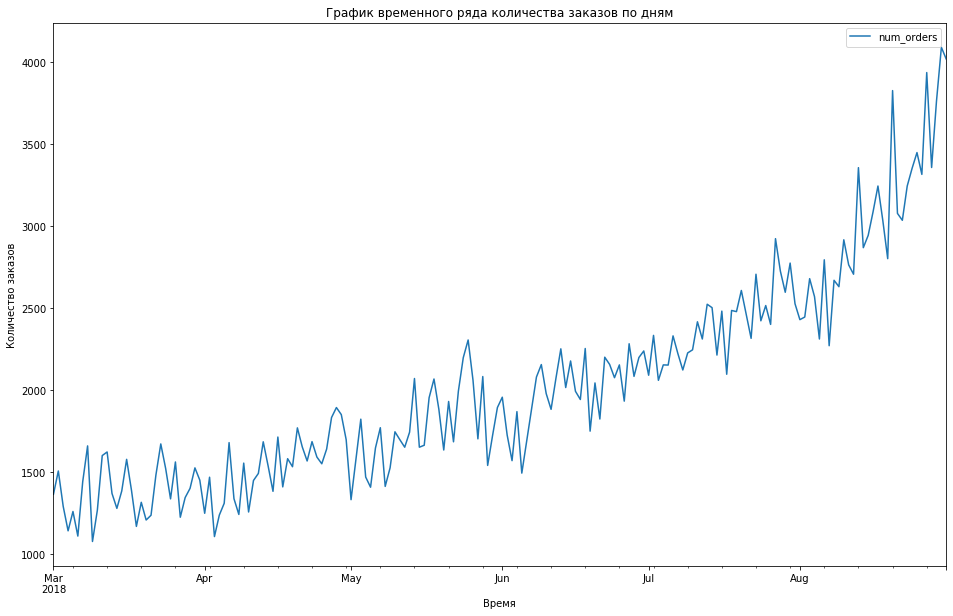

In [10]:
ax = df.resample("1D").sum().plot(figsize=(16, 10))
ax.set_title("График временного ряда количества заказов по дням")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время");

In [11]:
data = df.resample("1D").sum()

In [12]:
data['rolling_mean'] = data.rolling(7).mean()

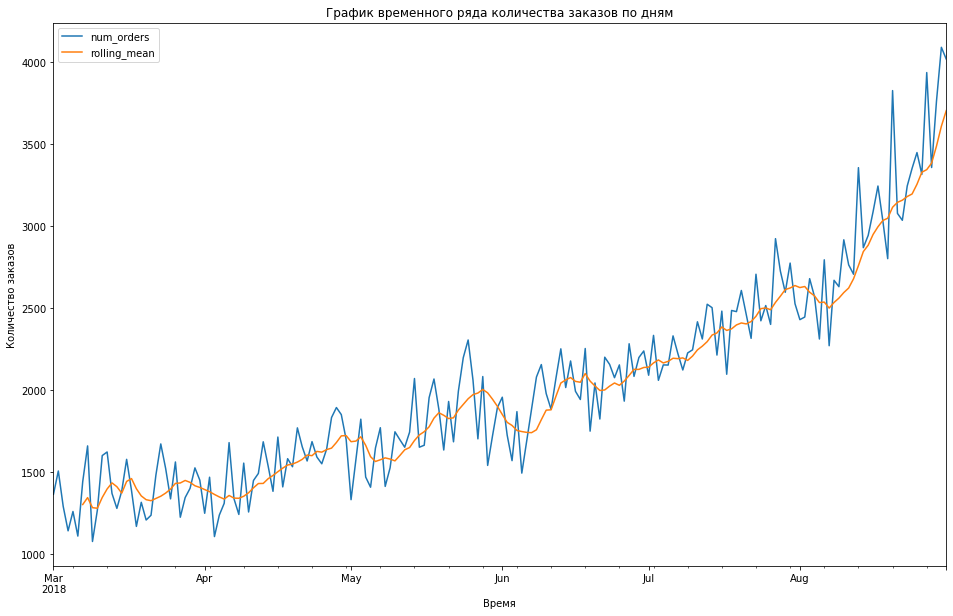

In [13]:
ax = data.plot(figsize=(16, 10))
ax.set_title("График временного ряда количества заказов по дням")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время");

In [14]:
decomposed = seasonal_decompose(df) 

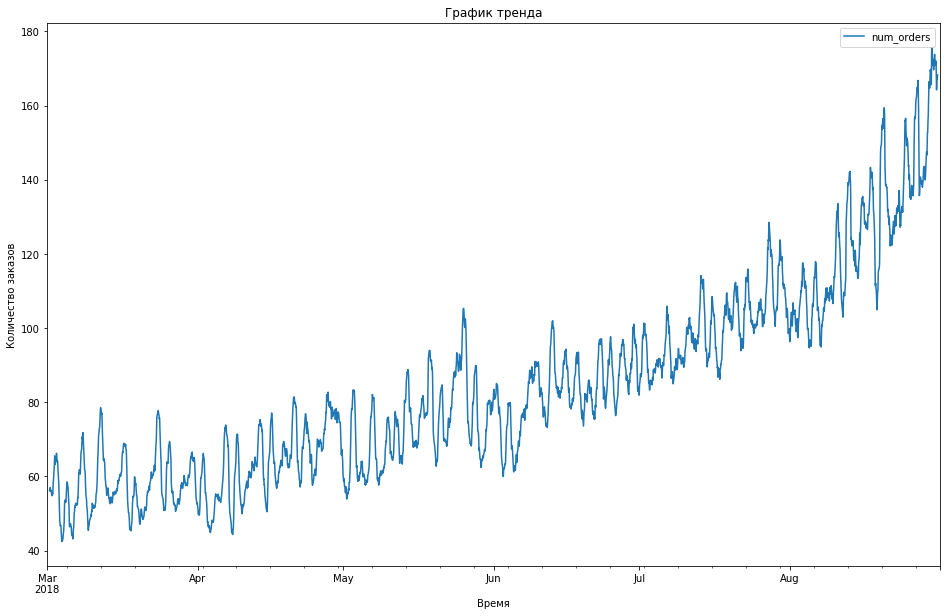

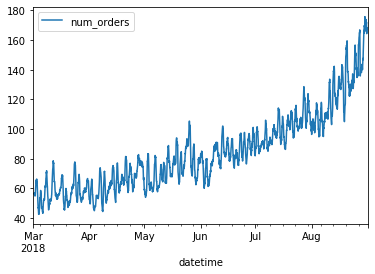

In [15]:
ax = decomposed.trend.plot(figsize=(16, 10))
ax.set_title("График тренда")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время");
decomposed.trend.plot()

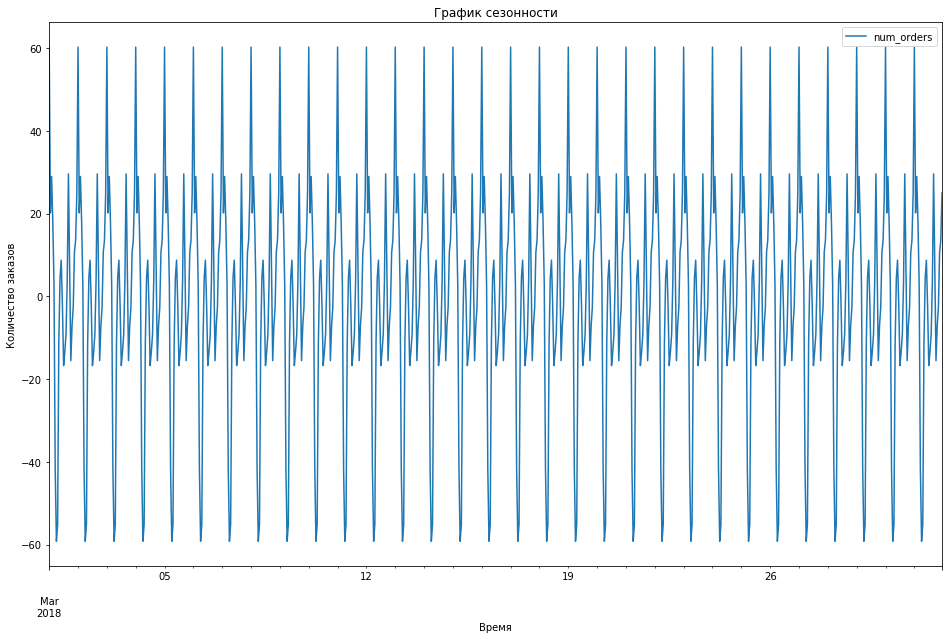

In [16]:
ax = decomposed.seasonal['2018-03':'2018-03'].plot(figsize=(16, 10))
ax.set_title("График сезонности")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время");

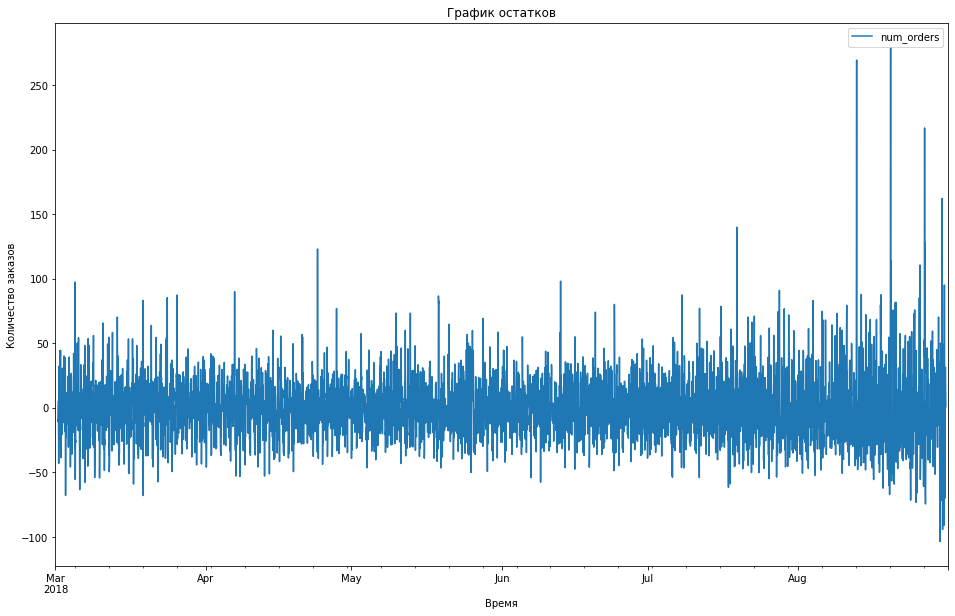

In [17]:
ax = decomposed.resid.plot(figsize=(16, 10))
ax.set_title("График остатков")
ax.set_ylabel("Количество заказов")
ax.set_xlabel("Время");

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
def split(data):
    train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=47)
    X_train = train.drop("num_orders", axis=1)
    y_train = train["num_orders"]
    X_test = test.drop("num_orders", axis=1)
    y_test = test["num_orders"]
    return train, test, X_train, y_train, X_test, y_test

In [20]:
df = make_features(df, 25, 3)

In [21]:
df = df.dropna()

In [22]:
train, test, X_train, y_train, X_test, y_test = split(df)

In [23]:
def fit_predict_evaluate_test(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, pred))

# 3. Обучение

### Decision Tree¶

In [24]:
params = {'min_samples_leaf': range(2,10),
    'min_samples_split':range(2,10),
    'max_depth' : range(2,10)}

In [25]:
model = DecisionTreeRegressor()

In [26]:
clf = GridSearchCV(estimator=model, param_grid=params,  cv=TimeSeriesSplit(n_splits=5),  
                   n_jobs=-1, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split

In [27]:
clf.best_params_

{'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 4}

In [28]:
clf.best_score_

-875.7281617634299

### LinearRegression

In [29]:
params = {'fit_intercept':[True, False],
    'normalize':[True, False],
    'copy_X' : [True, False]}

In [30]:
model = LinearRegression()

In [31]:
clf = GridSearchCV(estimator=model, param_grid=params,  cv=TimeSeriesSplit(n_splits=5),  
                   n_jobs=-1, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [32]:
clf.best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [33]:
clf.best_score_

-745.1681243193353

### Random Forest

In [34]:
params = {'n_estimators': [50, 100],
    'max_depth':range(3, 10),
    'min_samples_split' : range(3, 5),
    "min_samples_leaf": range(3, 5)}

In [35]:
model = RandomForestRegressor()

In [36]:
clf = GridSearchCV(estimator=model, param_grid=params,  cv=TimeSeriesSplit(n_splits=5),  
                   n_jobs=-1, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1

In [37]:
clf.best_params_

{'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 100}

In [38]:
clf.best_score_

-698.1249935091656

# 4. Тестирование

### Прогноз константой

In [39]:
pred_median = np.ones(test.shape[0]) * train['num_orders'].median()

In [40]:
np.sqrt(metrics.mean_squared_error(y_test, pred_median))

87.21093811714634

### Прогноз предыдущим значением ряда

In [41]:
pred_previous = test["num_orders"].shift()

In [42]:
pred_previous = pred_previous.fillna(0)

In [43]:
np.sqrt(metrics.mean_squared_error(y_test, pred_previous))

59.262187085711055

### Linear Regression


In [44]:
model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True)

In [45]:
fit_predict_evaluate_test(model)

45.56797416327436

### Decision Tree¶

In [46]:
model =  DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 8, min_samples_split = 4)

In [47]:
fit_predict_evaluate_test(model)

53.02100267008759

### Random Forest

In [48]:
model = RandomForestRegressor(max_depth = 4, min_samples_leaf = 4, min_samples_split = 3, n_estimators = 100)

In [49]:
fit_predict_evaluate_test(model)

49.62613316018785

Луший результат в данном случае дает линейная регрессия с RMSE 45.